In [294]:
# install.packages("stargazer")
#install.packages("mvtnorm")
#install.packages("emmeans")
#install.packages("plyr")
#install.packages("magrittr")
#install.packages("dplyr")
#install.packages("svglite")
#install.packages("gridExtra")

In [1]:
library("reshape2")
library("stargazer")
library("ggplot2")
library("magrittr")
library("plyr")
library("dplyr")
library("grid")
library("gridExtra")
#library("svglite")
#library("emmeans")


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
absPath = '/home/angela/padding_EBI/'

In [3]:
file_scores <- "scores_final.csv"
file_accuracy <- "accu_final.csv"

### Defining functions

In [4]:
postproc_lm <- function(lm_res){
    sm <- summary(lm_res)
    sm_df <- as.data.frame(sm$coefficients)
    colnames(sm_df) <- c("Estimate", "Std.Error", "t.value", "p_val")
    sm_df["p_adjusted"] = p.adjust(sm_df$p_val, method = "fdr")
    index <- sm_df["p_adjusted"] >= 0.05
    #sm_df$Estimate[index] <- 0
    return(sm_df)
}

dividing_rownames <- function(group, df){
    names <- c()
    estimates <- c()
    pvals <- c()
    indices <- grep(group,rownames(df))
    subgroup <- rownames(df)[indices]
    for (i in 1:length(subgroup)){
        sg <- unlist(strsplit(subgroup[i], group)[1])[2]
        names <- c(names, sg)
        estimates <- c(estimates, df[subgroup[i], "Estimate"])
        pvals <- c(pvals, df[subgroup[i], "p_adjusted"])
              }
    mini_df <- data.frame("estimates"=estimates, "p_valor"=pvals)
    mini_df$significant <- mini_df["p_valor"] < 0.05
    rownames(mini_df) <- names
    mini_df[group] <- rownames(mini_df)
    mini_df["x"] <- 1
    return(mini_df)
}    

values_significant <- c("black", NA)
names(values_significant) <- c(TRUE, FALSE)

separating_interactions <- function(group1, group2, df){
    estimates_list <- c()
    xs <- c()
    ys <- c()
    interactions <- grep(":", rownames(df))
    df_int <- df[interactions,]
    df_esti <- df[-interactions,]
    pvals_list <- c()
    for (i in 1:length(rownames(df_int))){
        sg <- unlist(strsplit(rownames(df_int)[i], ":")[1])
        x <- unlist(strsplit(sg[1], group1)[1])[2]
        y <- unlist(strsplit(sg[2], group2)[1])[2]
        estimates_list <- c(estimates_list, df[rownames(df_int)[i], "Estimate"])
        pvals_list <- c(pvals_list, df_int[rownames(df_int)[i], "p_adjusted"])
        xs <- c(xs, x)
        ys <- c(ys, y)
        }
    interactions_df <- data.frame("estimates"=estimates_list, "x"=xs, "y"=ys, "p_val"=pvals_list)
    interactions_df$significant <- interactions_df$p_val < 0.05
    newList <- list("estimates_df"=df_esti, "interactions_df"=interactions_df)
    return(newList)

}

plotting_additive <- function(group, df){
    ggplot(df, aes_string( x="x", y=group)) +
geom_tile(aes(fill = estimates), colour = "white", height=1, width=1) + 
geom_tile(aes(color=significant), fill=NA, size=0.5, height=1, width=1) + 
scale_fill_gradient2(limits=c(-1, 1)) + 
scale_color_manual(values= values_significant) +  
theme_bw() + 
theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank(),
     axis.title.y=element_blank(), axis.text.y=element_text(size=11))+ 
coord_equal()
}

plotting_interactions <- function(df){
    ggplot(df$interactions_df, aes( x=x, y=y)) +
geom_tile(aes(fill = estimates), colour = "white") + 
geom_tile(aes(color=significant), fill=NA, size=0.5) + 
scale_fill_gradient2(limits=c(-1, 1)) + 
scale_color_manual(values= values_significant) +  
theme_bw() + 
theme(axis.title.x=element_blank(), axis.ticks.x=element_blank(),
     axis.title.y=element_blank(), axis.text.y=element_text(size=11),
     axis.text.x=element_text(size=10)) +
coord_equal()
    
}


plot_coefs_inter <- function(mod, method.adjust = "fdr", q.signif = .05) {
    df.coef <- as.data.frame(summary(mod)$coef)
    
    nm <- rownames(df.coef)
    nm.split <- strsplit(nm, split = ":")
    
    df.coef$x1 <- sapply(nm.split, function(x) x[[1]])
    df.coef$x2 <- sapply(nm.split, function(x) {
        if (length(x) < 2) return("No interaction")
        x[[2]]
    })
    df.coef$p.adjust <- p.adjust(df.coef$`Pr(>|t|)`, method = method.adjust)
    df.coef$Significance <- ifelse(
        df.coef$p.adjust < q.signif, 
        paste0("q<", q.signif), paste0("q>=", q.signif))
                         
    #añadido por angela 30/12/19
    #df.coef$Sign <- ifelse((df.coef$Estimate) & < 0, "-", "+")
    df.coef$Sign[df.coef$p.adjust>0.05] <- ' '    
    df.coef$Sign[(df.coef$p.adjust<=0.05)&(df.coef$Estimate>=0)] <- '+'
    df.coef$Sign[(df.coef$p.adjust<=0.05)&(df.coef$Estimate<0)] <- '-'
                    
    values_significant <- c("black", NA)
    names(values_significant) <- c(paste0("q<", q.signif), paste0("q>=", q.signif))
    
    
    # if (is.null(order.vars)) {
    #     message("order.vars not supplied. Sorting alphabetically...")
    #     order.vars <- unique(sort(sapply(nm.split, function(x) x[[1]])))
    # }
    
    var.factor <- mod$xlevels
    df.factor <- plyr::ldply(
        names(var.factor), 
        function(x) {
            data.frame(
                var.name = x, 
                var.level = var.factor[[x]], 
                x = paste0(x, var.factor[[x]]), 
                stringsAsFactors = FALSE
            )
        }
    )
                         
    labs_new <- c("arch.", "enz", "Int.", "pad.")
    names(labs_new) <- c("architecture", "enz_type", "(Intercept)", "type_padding")
    
    df.coef %<>% 
        join(rename_all(df.factor, function(x) paste0(x, "1"))) %>%
        join(rename_all(df.factor, function(x) paste0(x, "2"))) %>%
        mutate(facet1 = ifelse(is.na(var.name1), x1, var.name1), 
               facet2 = ifelse(is.na(var.name2), x2, var.name2), 
               tick1 = ifelse(is.na(var.level1), x1, var.level1), 
               tick2 = ifelse(is.na(var.level2), x2, var.level2))
    
    ggplot(df.coef, aes(x = tick1, y = tick2 
                        #,fill = Estimate 
                        #,colour = Significance
                       )) +
        #geom_tile(lwd = 2) +
        geom_tile(aes(fill=Estimate)) +
        geom_tile(aes(color=Significance), fill=NA, size=0.5) +
        scale_colour_manual(values = values_significant) +
        scale_fill_gradient2(low = "cornflowerblue", mid = "gray90", high = "indianred", limits=c(-1, 1)) +
        facet_grid(facet2~facet1, scales = "free", space = "free", 
                   labeller=labeller(facet1=labs_new)) +
        #añadido por angela 30/12
        geom_text(aes(label=Sign), size=7) +
        theme_bw() +
        theme(aspect.ratio = 1, 
              panel.grid = element_blank(), 
              strip.text.y = element_text(angle = 0), 
              axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
              #, legend.position = "none"
             #strip.text.x = element_text(size=9)
             ) +
        # he intentado que el cuadrado de la leyenda salga bien pero esta pocho
        # guides(colour = guide_legend(fill = "white")) + 
        xlab("") +
        ylab("")
}
                    

#mod <- lm(Sepal.Length ~ Sepal.Width + Species*Petal.Width, data = iris)
#plot_coefs_inter(mod)
#plot_coefs_inter(mod, q.signif = 1e-5)

### Defining equations

In [5]:
equation1 <- formula(f1_score~architecture+enz_type+type_padding)
equation2 <- formula(f1_score~enz_type+type_padding)
equation3 <- formula(f1_score~architecture+enz_type+type_padding+type_padding:architecture)
equation4 <- formula(f1_score~architecture+enz_type+type_padding+type_padding:enz_type)

# Task 1

In [6]:
task <- "task1/"

path_scores_task1 <- paste0(absPath, "data/results/", task, file_scores)
#path_accu_task1 <- paste0(absPath, "data/results/", task, file_accuracy)

scores_task1 <- read.csv(file=path_scores_task1, header=TRUE, sep=",")
#accu_task1 <- read.csv(file=path_accu_task1, header=TRUE, sep=",")

## Scores

In [7]:
scores_task1[0:5,]
scores_task1$X <- NULL
#filtering 
scores_task1 <- scores_task1[scores_task1$enz_type %in% c(0,1),]
sapply(scores_task1, class)
# habria que hacer un unmelt de variable-value
scores_task1_dcasted <- dcast(data = scores_task1,formula = enz_type+index+type_padding+architecture~variable,
                              fun.aggregate = sum,value.var = "value")
#tengo que cambiar el nombre de f1-score
colnames(scores_task1_dcasted) <- c("enz_type", "index", "type_padding", "architecture", "f1_score",
                                    "precision", "recall")
scores_task1_dcasted[0:5,]

X,enz_type,index,type_padding,architecture,variable,value
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
0,0,0,post_padding,1_conv,f1-score,0.8548043
1,1,0,post_padding,1_conv,f1-score,0.8642715
2,micro avg,0,post_padding,1_conv,f1-score,0.8596974
3,macro avg,0,post_padding,1_conv,f1-score,0.8595379
4,weighted avg,0,post_padding,1_conv,f1-score,0.8600099


enz_type        index type_padding architecture     variable        value 
    "factor"    "integer"     "factor"     "factor"     "factor"    "numeric"

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
0,0,aug_padding,1_conv,0.7512593,0.6471795,0.8952308
0,0,aug_padding,only_denses,0.8760426,0.8434343,0.9112736
0,0,aug_padding,stack_conv,0.7811460,0.6844007,0.9097457
0,0,ext_padding,1_conv,0.8403179,0.7971213,0.8884645
0,0,ext_padding,only_denses,0.8888097,0.8329993,0.9526356


# 0.Full additive model

## changing reference

In [8]:
scores_task1_dcasted$architecture <- relevel(scores_task1_dcasted$architecture, "only_denses")
scores_task1_dcasted$type_padding <- relevel(scores_task1_dcasted$type_padding, "post_padding")

In [9]:
lm_f1_task1_additive <- lm(equation1, data=scores_task1_dcasted)

In [10]:
summary(lm_f1_task1_additive)


Call:
lm(formula = equation1, data = scores_task1_dcasted)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20864 -0.01473  0.00259  0.01725  0.06311 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               9.164e-01  4.069e-03 225.221  < 2e-16 ***
architecture1_conv       -6.329e-02  3.005e-03 -21.061  < 2e-16 ***
architecturestack_conv   -5.235e-02  3.005e-03 -17.421  < 2e-16 ***
enz_type1                 1.239e-02  2.454e-03   5.048 6.41e-07 ***
type_paddingaug_padding  -6.870e-02  4.907e-03 -13.999  < 2e-16 ***
type_paddingext_padding  -1.290e-02  4.907e-03  -2.628  0.00887 ** 
type_paddingmid_padding   6.469e-05  4.907e-03   0.013  0.98949    
type_paddingpre_padding  -1.068e-02  4.907e-03  -2.176  0.03007 *  
type_paddingrnd_padding  -5.257e-02  4.907e-03 -10.712  < 2e-16 ***
type_paddingstrf_padding -1.089e-03  4.907e-03  -0.222  0.82445    
type_paddingzoom_padding -9.626e-03  4.907e-03  -1.962  0.05040 .  
---
S

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


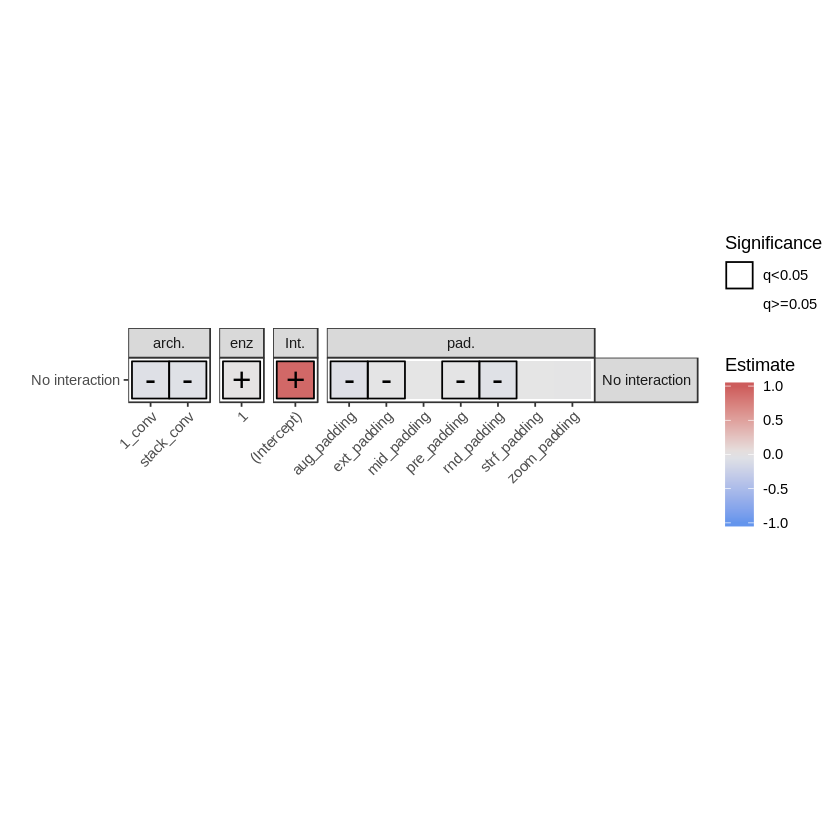

In [11]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g1_task1 = plot_coefs_inter(lm_f1_task1_additive)
g1_task1
ggsave("full_additive.eps", device="eps", path=file_path)

In [12]:
sm0_df <- postproc_lm(lm_f1_task1_additive)
sm0_df

,Estimate,Std.Error,t.value,p_val,p_adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),9.163729e-01,0.004068765,225.22135931,0.000000e+00,0.000000e+00
architecture1_conv,-6.328732e-02,0.003004982,-21.06079467,8.528275e-70,4.690551e-69
architecturestack_conv,-5.235050e-02,0.003004982,-17.42123361,8.820571e-53,3.234209e-52
enz_type1,1.238517e-02,0.002453558,5.04784149,6.405137e-07,1.174275e-06
type_paddingaug_padding,-6.869563e-02,0.004907116,-13.99918661,1.866753e-37,5.133572e-37
type_paddingext_padding,-1.289588e-02,0.004907116,-2.62799515,8.870553e-03,1.393944e-02
type_paddingmid_padding,6.469193e-05,0.004907116,0.01318329,9.894872e-01,9.894872e-01
type_paddingpre_padding,-1.067660e-02,0.004907116,-2.17573883,3.007336e-02,4.135087e-02
type_paddingrnd_padding,-5.256738e-02,0.004907116,-10.71248110,4.209378e-24,9.260631e-24


In [13]:
# Dividing lm in representable tiles
arch_df_0 <- dividing_rownames("architecture", sm0_df)
enz_df_0 <- dividing_rownames("enz_type", sm0_df)
pad_df_0 <- dividing_rownames("type_padding", sm0_df)

In [104]:
# comparison predictions
new_df <- data.frame("enz_type" = c("0", "0", "0"), 
                     "type_padding" = c("post_padding", "post_padding", "post_padding"), 
                     "architecture" = c("stack_conv", "1_conv", "only_denses"))
predict(lm_f1_task1_additive, new_df)

1         2         3 
0.8640224 0.8530856 0.9163729

In [14]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_1)

In [15]:
#options(repr.plot.width=2.25, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_1)

In [16]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_1)

# A. Does padding position affect performance?

In [17]:
#choosing_levels
soa_arch <- c("only_denses")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding", "ext_padding", "strf_padding",
            "zoom_padding", "aug_padding")
lm_f1_task1_A <- lm(equation2, 
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch & 
                                           type_padding %in% soa_pad))
summary(lm_f1_task1_A)


Call:
lm(formula = equation2, data = subset(scores_task1_dcasted, architecture %in% 
    soa_arch & type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041921 -0.009628  0.002466  0.010496  0.031514 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.8960292  0.0035231 254.333  < 2e-16 ***
enz_type1                 0.0081015  0.0024912   3.252  0.00145 ** 
type_paddingaug_padding  -0.0001935  0.0046606  -0.042  0.96695    
type_paddingext_padding  -0.0041699  0.0046606  -0.895  0.37257    
type_paddingmid_padding   0.0105087  0.0046606   2.255  0.02579 *  
type_paddingpre_padding  -0.0008379  0.0046606  -0.180  0.85760    
type_paddingstrf_padding  0.0300487  0.0046606   6.447 1.97e-09 ***
type_paddingzoom_padding -0.0067748  0.0046606  -1.454  0.14842    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01474 on 132 degrees of freedom
Mul

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


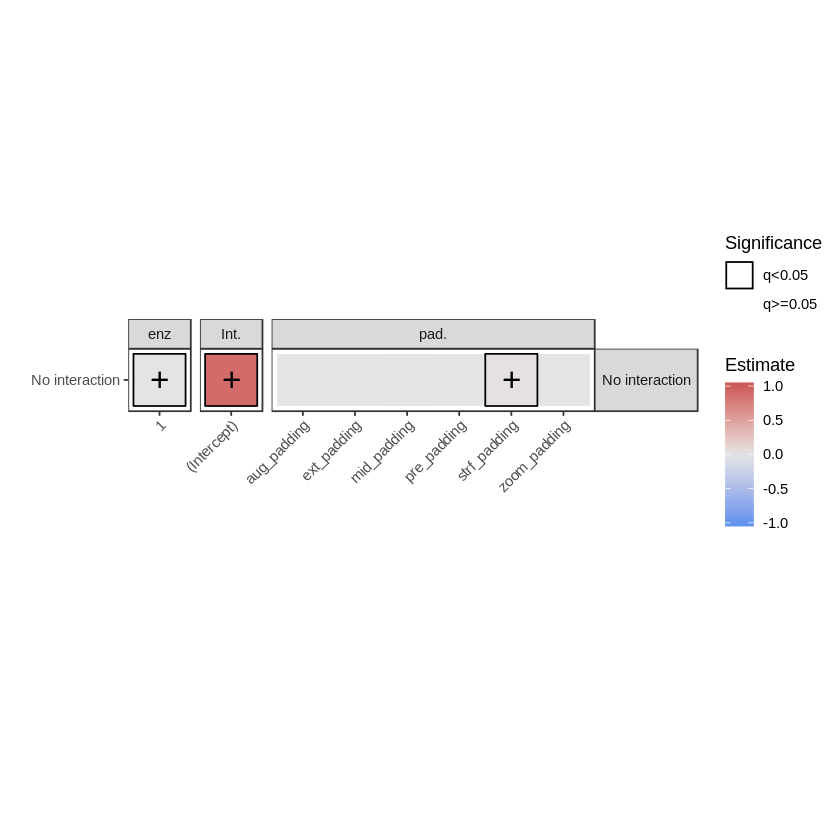

In [18]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g2_task1 = plot_coefs_inter(lm_f1_task1_A)
g2_task1
ggsave("A.eps", device="eps", path=file_path)

In [19]:
A_df <- postproc_lm(lm_f1_task1_A)
enz_df_A <- dividing_rownames("enz_type", A_df)
pad_df_A <- dividing_rownames("type_padding", A_df)

In [81]:
# comparison predictions
new_df <- data.frame("enz_type" = c("0", "0"), "type_padding" = c("strf_padding", "post_padding"), 
                     "architecture" = c("only_denses", "only_denses"))
predict(lm_f1_task1_A, new_df)

1         2 
0.9260778 0.8960292

1         2 
0.8960292 0.8951913

## B. What is the effect of switching between dense paddings?

In [20]:
soa_arch <- c("stack_conv")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding")
lm_f1_task1_B <- lm(equation2,
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch 
                                           & type_padding %in% soa_pad))

In [21]:
summary(lm_f1_task1_B)


Call:
lm(formula = equation2, data = subset(scores_task1_dcasted, architecture %in% 
    soa_arch & type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.080301 -0.009995  0.001617  0.015475  0.041790 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.876330   0.005811 150.802   <2e-16 ***
enz_type1                0.005626   0.005198   1.082   0.2825    
type_paddingext_padding -0.003933   0.007351  -0.535   0.5942    
type_paddingmid_padding -0.005576   0.007351  -0.759   0.4505    
type_paddingpre_padding -0.016601   0.007351  -2.258   0.0268 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02324 on 75 degrees of freedom
Multiple R-squared:  0.08299,	Adjusted R-squared:  0.03409 
F-statistic: 1.697 on 4 and 75 DF,  p-value: 0.1596


Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


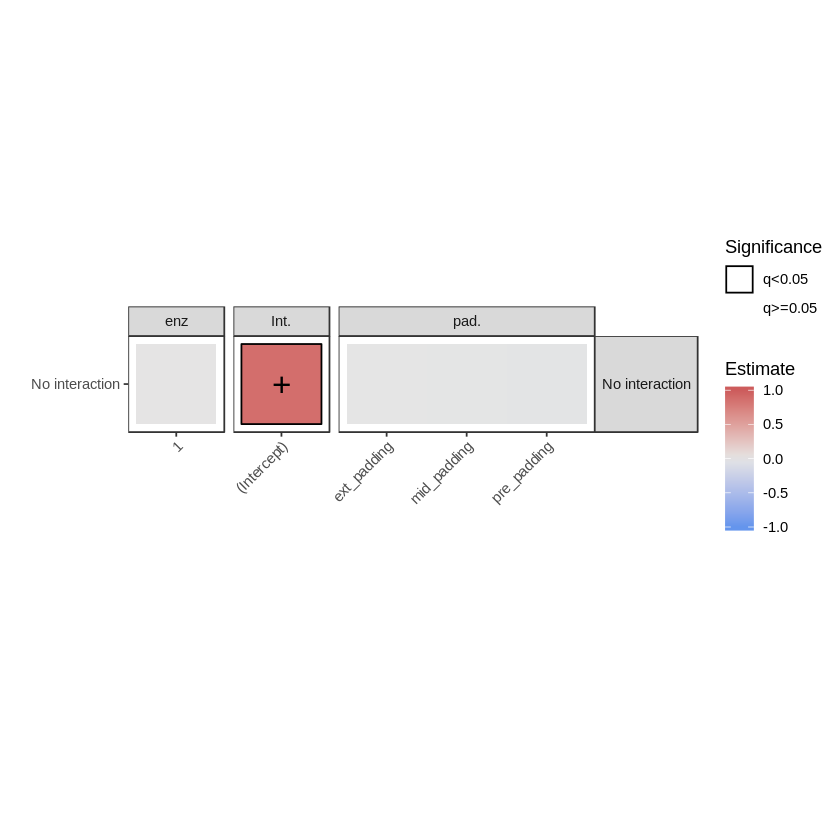

In [22]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g2_task1 = plot_coefs_inter(lm_f1_task1_B)
g2_task1
ggsave("B.eps", device="eps", path=file_path)


In [23]:
B_df <- postproc_lm(lm_f1_task1_B)
#sm2_df_proc <- separating_interactions("architecture", "type_padding", sm2_df)

In [24]:
# Dividing lm in representable tiles
#arch_df_2 <- dividing_rownames("architecture", sm2_df_proc$estimates_df)
#enz_df_B <- dividing_rownames("enz_type", sm2_df_proc$estimates_df)
#pad_df_B <- dividing_rownames("type_padding", sm2_df_proc$estimates_df)
enz_df_B <- dividing_rownames("enz_type", B_df)
pad_df_B <- dividing_rownames("type_padding", B_df)

In [25]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_2)

In [26]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_2)

In [27]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_2)

In [28]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm2_df_proc)

## C. What is the effect of changing from the standard dense padding to sparse padding?

In [29]:
# interactions non significant
soa2_pad <- c("post_padding", "strf_padding", "rnd_padding", "zoom_padding")
lm_f1_task1_C <- lm(equation2, 
                               data=subset(scores_task1_dcasted, architecture %in% soa_arch 
                                           & type_padding %in% soa2_pad))
summary(lm_f1_task1_C)


Call:
lm(formula = equation2, data = subset(scores_task1_dcasted, architecture %in% 
    soa_arch & type_padding %in% soa2_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.071659 -0.007650  0.001943  0.010807  0.034880 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.868249   0.004332 200.421  < 2e-16 ***
enz_type1                 0.021787   0.003875   5.623 3.06e-07 ***
type_paddingrnd_padding  -0.066916   0.005480 -12.211  < 2e-16 ***
type_paddingstrf_padding -0.027942   0.005480  -5.099 2.48e-06 ***
type_paddingzoom_padding -0.016820   0.005480  -3.070  0.00298 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01733 on 75 degrees of freedom
Multiple R-squared:  0.7202,	Adjusted R-squared:  0.7053 
F-statistic: 48.26 on 4 and 75 DF,  p-value: < 2.2e-16


Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


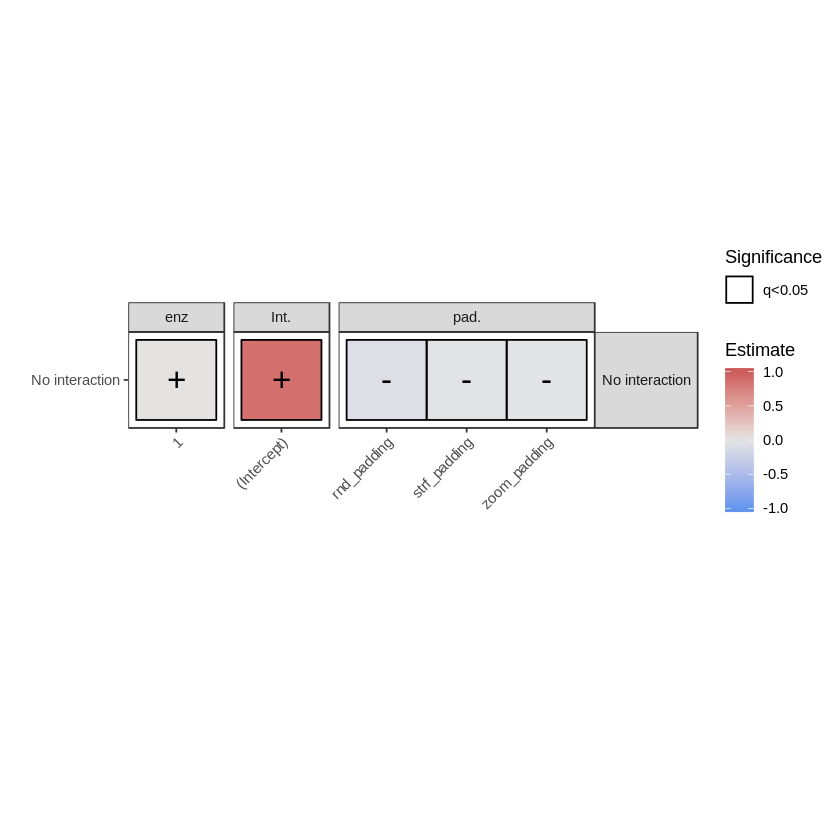

In [30]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g3_task1 = plot_coefs_inter(lm_f1_task1_C)

g3_task1
ggsave("C.eps", device="eps", path=file_path)

In [31]:
C_df <- postproc_lm(lm_f1_task1_C)
#sm3_df_proc <- separating_interactions("architecture", "type_padding", sm3_df)

# Dividing lm in representable tiles
enz_df_C <- dividing_rownames("enz_type", C_df)
pad_df_C <- dividing_rownames("type_padding", C_df)
#arch_df_3 <- dividing_rownames("architecture", sm3_df_proc$estimates_df)
#enz_df_3 <- dividing_rownames("enz_type", sm3_df_proc$estimates_df)
#pad_df_3 <- dividing_rownames("type_padding", sm3_df_proc$estimates_df)

In [86]:
# comparison predictions
new_df <- data.frame("enz_type" = c("0", "0", "0", "0"), "type_padding" = c("strf_padding", "rnd_padding", 
                                                                            "zoom_padding", "post_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv", "stack_conv"))
predict(lm_f1_task1_C, new_df)

1         2         3         4 
0.8403070 0.8013334 0.8514290 0.8682492

In [32]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_3)

In [33]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_3)

In [34]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_3)

In [35]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm3_df_proc)

In [36]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_4)

In [37]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_4)

# D. Is an ensemble of paddings beneficial?

In [38]:
soa_pad <- c("post_padding", "strf_padding", "aug_padding")
#changing reference 
scores_task1_dcasted$architecture <- relevel(scores_task1_dcasted$architecture, "stack_conv")
scores_task1_dcasted$type_padding <- relevel(scores_task1_dcasted$type_padding, "aug_padding")

lm_f1_task1_D <- lm(equation3, data=subset(scores_task1_dcasted, 
                                           type_padding %in% soa_pad))
summary(lm_f1_task1_D)


Call:
lm(formula = equation3, data = subset(scores_task1_dcasted, type_padding %in% 
    soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.172396 -0.010122  0.002626  0.009788  0.056167 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                       0.785555   0.005151 152.509
architectureonly_denses                           0.109864   0.006911  15.898
architecture1_conv                               -0.033960   0.006911  -4.914
enz_type1                                         0.008935   0.003258   2.743
type_paddingpost_padding                          0.089120   0.006911  12.896
type_paddingstrf_padding                          0.061178   0.006911   8.853
architectureonly_denses:type_paddingpost_padding -0.088927   0.009773  -9.099
architecture1_conv:type_paddingpost_padding       0.027653   0.009773   2.830
architectureonly_denses:type_paddingstrf_padding -0.030936   0.009773

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


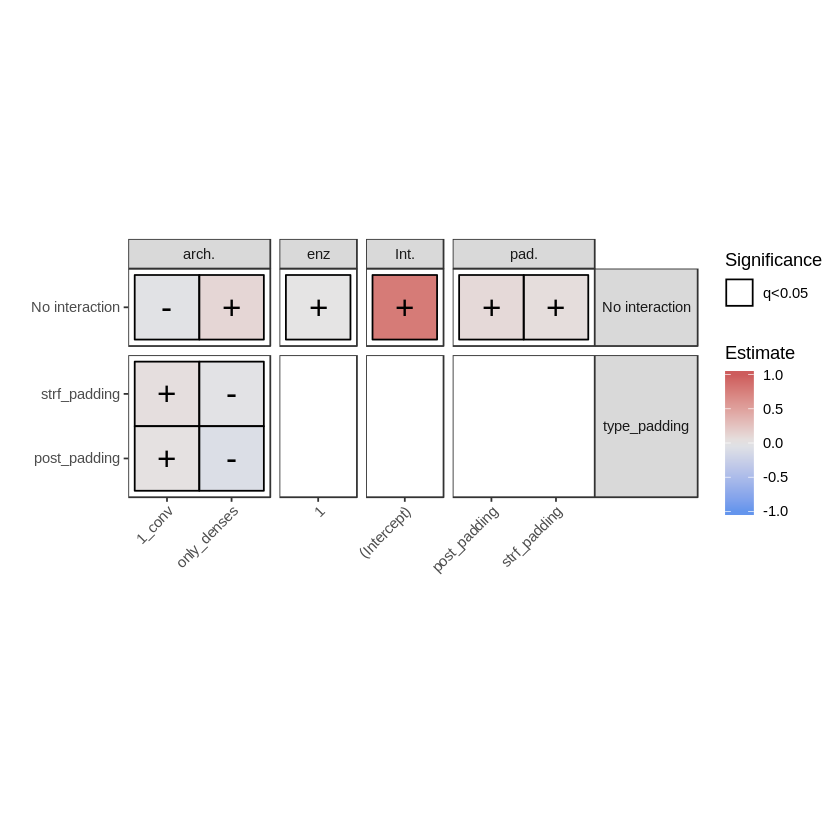

In [39]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g5_task1 <- plot_coefs_inter(lm_f1_task1_D)
g5_task1
ggsave("D.eps", device="eps", path=file_path)


In [40]:
D_df <- postproc_lm(lm_f1_task1_D)
D_df_proc <- separating_interactions("architecture", "type_padding", D_df)

In [41]:
# Dividing lm in representable tiles
arch_df_D <- dividing_rownames("architecture", D_df_proc$estimates_df)
enz_df_D <- dividing_rownames("enz_type", D_df_proc$estimates_df)
pad_df_D <- dividing_rownames("type_padding", D_df_proc$estimates_df)

In [90]:
# comparison predictions
new_df <- data.frame("enz_type" = c("0", "0", "0"), "type_padding" = c("aug_padding", "post_padding", 
                                                                            "strf_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv"))
predict(lm_f1_task1_D, new_df)

1         2         3 
0.7855551 0.8746752 0.8467329

In [91]:
new_df <- data.frame("enz_type" = c("0", "0", "0"), "type_padding" = c("aug_padding", "aug_padding", 
                                                                            "aug_padding"), 
                     "architecture" = c("stack_conv", "1_conv", "only_denses"))
predict(lm_f1_task1_D, new_df)

1         2         3 
0.7855551 0.7515947 0.8954188

In [92]:
new_df <- data.frame("enz_type" = c("0", "0", "0"), "type_padding" = c("aug_padding", "strf_padding", 
                                                                            "post_padding"), 
                     "architecture" = c("stack_conv", "1_conv", "1_conv"))
predict(lm_f1_task1_D, new_df)

1         2         3 
0.7855551 0.8629943 0.8683681

In [95]:
new_df <- data.frame("enz_type" = c("0", "0", "0", "0", "0", "0"), "type_padding" = c("aug_padding", "strf_padding", 
                                                                            "post_padding", "aug_padding", 
                                                                       "strf_padding", 
                                                                            "post_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv", "1_conv", "1_conv", "1_conv"))
predict(lm_f1_task1_D, new_df)

1         2         3         4         5         6 
0.7855551 0.8467329 0.8746752 0.7515947 0.8629943 0.8683681

In [96]:
new_df <- data.frame("enz_type" = c("0", "0", "0", "0", "0", "0"), "type_padding" = c("aug_padding", "strf_padding", 
                                                                            "post_padding", "aug_padding", 
                                                                       "strf_padding", 
                                                                            "post_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv", "only_denses", "only_denses", 
                                        "only_denses"))
predict(lm_f1_task1_D, new_df)

1         2         3         4         5         6 
0.7855551 0.8467329 0.8746752 0.8954188 0.9256609 0.8956122

In [42]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_5)

In [43]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_5)

In [44]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_5)

In [45]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm5_df_proc)

# E. How does enzyme type might affect differentlythe performances of some padding types?

In [46]:
soa_pad <- c("post_padding", "strf_padding")
#scores_task1_dcasted_aug <- scores_task1_dcasted
#changing reference
scores_task1_dcasted$type_padding <- relevel(scores_task1_dcasted$type_padding, "post_padding")

lm_f1_task1_E <- lm(equation4, data=subset(scores_task1_dcasted, type_padding %in% soa_pad))
summary(lm_f1_task1_E)


Call:
lm(formula = equation4, data = subset(scores_task1_dcasted, type_padding %in% 
    soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.051774 -0.009807 -0.000451  0.011532  0.046835 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.861281   0.004159 207.088   <2e-16 ***
architectureonly_denses             0.049933   0.004159  12.006   <2e-16 ***
architecture1_conv                  0.004977   0.004159   1.197   0.2339    
enz_type1                           0.008870   0.004802   1.847   0.0673 .  
type_paddingstrf_padding           -0.005928   0.004802  -1.234   0.2196    
enz_type1:type_paddingstrf_padding  0.009678   0.006792   1.425   0.1569    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0186 on 114 degrees of freedom
Multiple R-squared:  0.6291,	Adjusted R-squared:  0.6128 
F-statistic: 38.67 on 5 and 114 DF,  p-value: < 

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


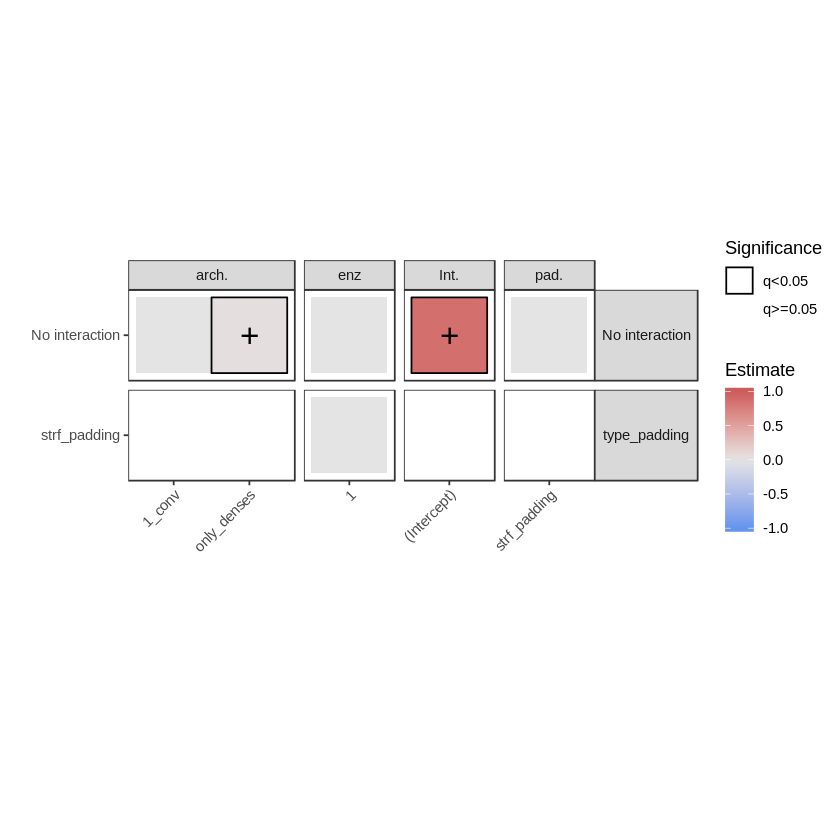

In [47]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g6_task1 <- plot_coefs_inter(lm_f1_task1_E)
g6_task1
ggsave("E.eps", device="eps", path=file_path)

In [48]:
E_df <- postproc_lm(lm_f1_task1_E)
E_df_proc <- separating_interactions("architecture", "type_padding", E_df)

In [49]:
# Dividing lm in representable tiles
arch_df_E <- dividing_rownames("architecture", E_df_proc$estimates_df)
enz_df_E <- dividing_rownames("enz_type", E_df_proc$estimates_df)
pad_df_E <- dividing_rownames("type_padding", E_df_proc$estimates_df)

## ESTA ULTIMA NO ES NECESARIA, SOLO TIENE SENTIDO PARA TASK 2

In [50]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df_6)

In [51]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df_6)

In [52]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df_6)

In [53]:
#options(repr.plot.width=4, repr.plot.height=3)
#plotting_interactions(sm6_df_proc)

# Task 2

In [54]:
task <- "task2/"

path_scores_task2 <- paste0(absPath, "data/results/", task, file_scores)
#path_accu_task2 <- paste0(absPath, "data/results/", task, file_accuracy)

scores_task2 <- read.csv(file=path_scores_task2, header=TRUE, sep=",")
#accu_task2 <- read.csv(file=path_accu_task2, header=TRUE, sep=",")

## Scores

In [55]:
scores_task2[0:5,]
dim(scores_task2)
scores_task2$X <- NULL

#filtering 
scores_task2 <- scores_task2[scores_task2$enz_type %in% c(1,2,3,4,5,6,7),]
dim(scores_task2)
sapply(scores_task2, class)

# habria que hacer un unmelt de variable-value
scores_task2_dcasted <- dcast(data = scores_task2, formula = enz_type+index+type_padding+architecture~variable,
                              fun.aggregate = sum,value.var = "value")

#tengo que cambiar el nombre de f1-score
colnames(scores_task2_dcasted) <- c("enz_type", "index", "type_padding", "architecture", "f1_score",
                                    "precision", "recall")
scores_task2_dcasted[0:5,]

X,enz_type,index,type_padding,architecture,variable,value
<int>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
0,1,0,post_padding,1_conv,f1-score,0.4609665
1,2,0,post_padding,1_conv,f1-score,0.6056475
2,3,0,post_padding,1_conv,f1-score,0.5493562
3,4,0,post_padding,1_conv,f1-score,0.4986877
4,5,0,post_padding,1_conv,f1-score,0.6060606


[1] 7200    7

[1] 5040    6

enz_type        index type_padding architecture     variable        value 
    "factor"    "integer"     "factor"     "factor"     "factor"    "numeric"

enz_type,index,type_padding,architecture,f1_score,precision,recall
<fct>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,0,aug_padding,1_conv,0.4514306,0.4031546,0.5128411
1,0,aug_padding,only_denses,0.4247295,0.3453997,0.5513644
1,0,aug_padding,stack_conv,0.4891587,0.5320755,0.4526485
1,0,ext_padding,1_conv,0.3833866,0.2678571,0.6741573
1,0,ext_padding,only_denses,0.5026738,0.4795918,0.5280899


# 0.Full additive model

## changing reference values

In [56]:
scores_task2_dcasted$architecture <- relevel(scores_task2_dcasted$architecture, "only_denses")
scores_task2_dcasted$type_padding <- relevel(scores_task2_dcasted$type_padding, "post_padding")

In [57]:
lm_f1_task2_additive <- lm(equation1, data=scores_task2_dcasted)

summary(lm_f1_task2_additive)


Call:
lm(formula = equation1, data = scores_task2_dcasted)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54382 -0.03001 -0.00083  0.03148  0.37667 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.443785   0.008134  54.560  < 2e-16 ***
architecture1_conv        0.020686   0.004981   4.153 3.45e-05 ***
architecturestack_conv    0.010155   0.004981   2.039   0.0416 *  
enz_type2                 0.167146   0.007609  21.968  < 2e-16 ***
enz_type3                 0.096535   0.007609  12.688  < 2e-16 ***
enz_type4                 0.008054   0.007609   1.059   0.2900    
enz_type5                 0.167209   0.007609  21.976  < 2e-16 ***
enz_type6                 0.044160   0.007609   5.804 7.74e-09 ***
enz_type7                 0.100034   0.007609  13.147  < 2e-16 ***
type_paddingaug_padding  -0.013552   0.008134  -1.666   0.0959 .  
type_paddingext_padding   0.008233   0.008134   1.012   0.3116    
type_paddingmid_p

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


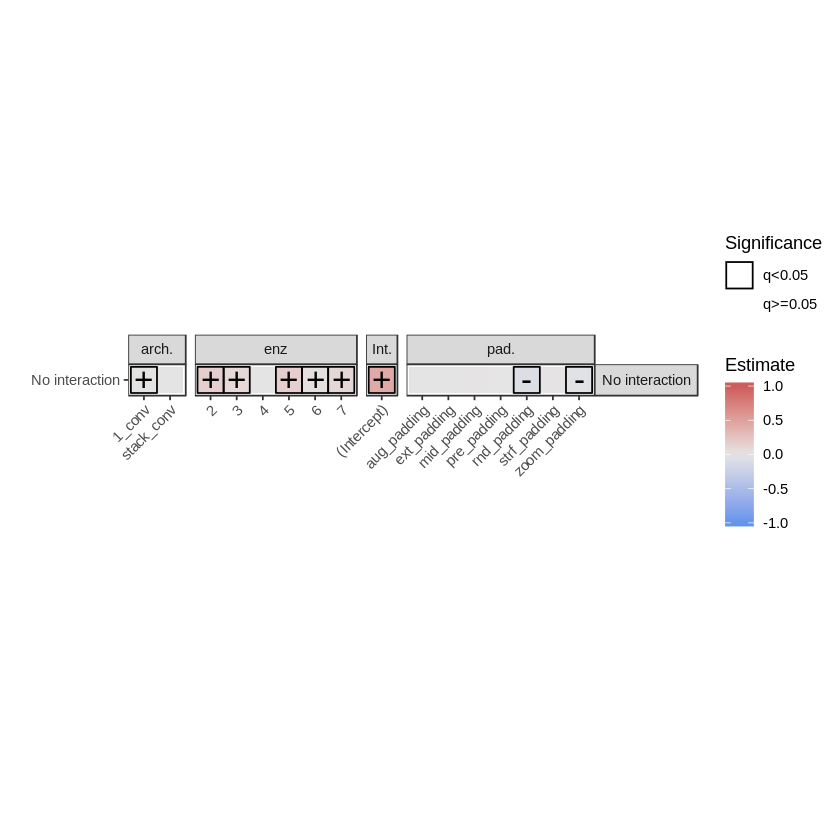

In [58]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g1_task2 <- plot_coefs_inter(lm_f1_task2_additive)
g1_task2

ggsave("full_additive.eps", device="eps", path=file_path)

In [59]:
df2_0 <- postproc_lm(lm_f1_task2_additive)
df2_0

# Dividing lm in representable tiles
arch_df2_0 <- dividing_rownames("architecture", df2_0)
enz_df2_0 <- dividing_rownames("enz_type", df2_0)
pad_df2_0 <- dividing_rownames("type_padding", df2_0)

,Estimate,Std.Error,t.value,p_val,p_adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.443784919,0.008133927,54.5597404,0.000000e+00,0.000000e+00
architecture1_conv,0.020686433,0.004980992,4.1530746,3.446647e-05,6.893294e-05
architecturestack_conv,0.010155471,0.004980992,2.0388450,4.162326e-02,6.659721e-02
enz_type2,0.167146063,0.007608592,21.9680688,3.960775e-94,2.112414e-93
enz_type3,0.096534757,0.007608592,12.6875987,2.816229e-35,9.011931e-35
enz_type4,0.008054171,0.007608592,1.0585626,2.899527e-01,3.313745e-01
enz_type5,0.167209427,0.007608592,21.9763968,3.436019e-94,2.112414e-93
enz_type6,0.044159634,0.007608592,5.8039170,7.741350e-09,1.769452e-08
enz_type7,0.100033559,0.007608592,13.1474477,1.233710e-37,4.934840e-37


In [105]:
# comparison predictions
new_df <- data.frame("enz_type" = c("1", "1", "1"), 
                     "type_padding" = c("post_padding", "post_padding", "post_padding"), 
                     "architecture" = c("stack_conv", "1_conv", "only_denses"))
predict(lm_f1_task2_additive, new_df)

1         2         3 
0.4539404 0.4644714 0.4437849

In [60]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("architecture", arch_df2_1)

In [61]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("enz_type", enz_df2_1)

In [62]:
#options(repr.plot.width=2.5, repr.plot.height=3)
#plotting_additive("type_padding", pad_df2_1)

# A. Does padding position affect performance?

In [63]:
#choosing_levels
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding", "ext_padding", "strf_padding",
            "zoom_padding", "aug_padding")
soa_arch = c("only_denses")
lm_f1_task2_A <- lm(equation2, data=subset(scores_task2_dcasted, architecture %in% soa_arch & 
                                           type_padding %in% soa_pad))
summary(lm_f1_task2_A)


Call:
lm(formula = equation2, data = subset(scores_task2_dcasted, architecture %in% 
    soa_arch & type_padding %in% soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49069 -0.03106 -0.00024  0.03885  0.41443 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.432488   0.016133  26.807  < 2e-16 ***
enz_type2                 0.158877   0.016742   9.490  < 2e-16 ***
enz_type3                 0.104954   0.016742   6.269 8.15e-10 ***
enz_type4                 0.005896   0.016742   0.352  0.72488    
enz_type5                 0.164581   0.016742   9.830  < 2e-16 ***
enz_type6                 0.053596   0.016742   3.201  0.00146 ** 
enz_type7                 0.044887   0.016742   2.681  0.00759 ** 
type_paddingaug_padding   0.022692   0.016742   1.355  0.17594    
type_paddingext_padding   0.033934   0.016742   2.027  0.04323 *  
type_paddingmid_padding   0.033732   0.016742   2.015  0.04449 *  
type_paddingpre

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


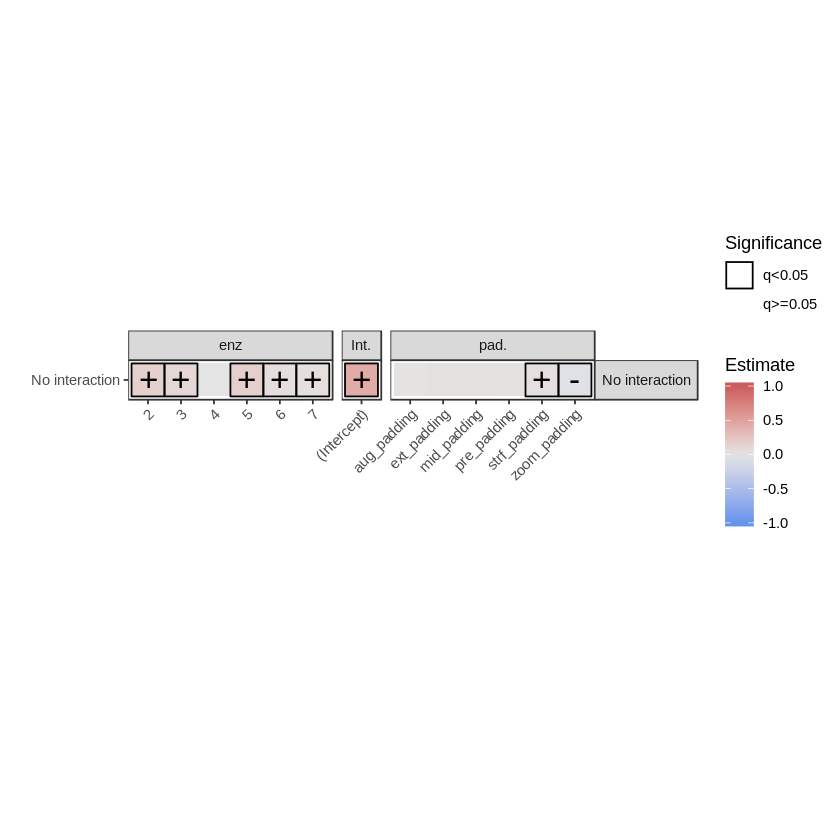

In [64]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g2_task2 <- plot_coefs_inter(lm_f1_task2_A)
g2_task2

ggsave("A.eps", device="eps", path=file_path)

In [65]:
A_df2 <- postproc_lm(lm_f1_task2_A)
#A_df2_proc <- separating_interactions("architecture", "type_padding", sm2_df2)

# Dividing lm in representable tiles
#arch_df2_A <- dividing_rownames("architecture", sm2_df2_proc$estimates_df)
enz_df2_A <- dividing_rownames("enz_type", A_df2)
pad_df2_A <- dividing_rownames("type_padding", A_df2)

In [83]:
# comparison predictions
new_df <- data.frame("enz_type" = c("1", "1", "1"), "type_padding" = c("strf_padding", "post_padding", 
                                                                       "zoom_padding"), 
                     "architecture" = c("only_denses", "only_denses", "only_denses"))
predict(lm_f1_task2_A, new_df)

1         2         3 
0.4723004 0.4324878 0.3793881

# B. What is the effect of switching between dense paddings?

In [66]:
soa_arch <- c("stack_conv")
soa_pad <- c("post_padding", "pre_padding", "mid_padding", "ext_padding")
lm_f1_task2_B <- lm(equation2,data=subset(scores_task2_dcasted, architecture %in% soa_arch 
                                           & type_padding %in% soa_pad))
summary(lm_f1_task2_B)


Call:
lm(formula = equation2, data = subset(scores_task2_dcasted, architecture %in% 
    soa_arch & type_padding %in% soa_pad))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.218032 -0.025983 -0.002036  0.026660  0.280054 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.483710   0.011663  41.472  < 2e-16 ***
enz_type2                0.156819   0.013800  11.363  < 2e-16 ***
enz_type3                0.060256   0.013800   4.366  1.8e-05 ***
enz_type4               -0.012944   0.013800  -0.938   0.3491    
enz_type5                0.136308   0.013800   9.877  < 2e-16 ***
enz_type6                0.024190   0.013800   1.753   0.0808 .  
enz_type7                0.124816   0.013800   9.044  < 2e-16 ***
type_paddingext_padding -0.013581   0.010432  -1.302   0.1941    
type_paddingmid_padding  0.003864   0.010432   0.370   0.7114    
type_paddingpre_padding -0.026858   0.010432  -2.575   0.0106 *  
---
Signif. code

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


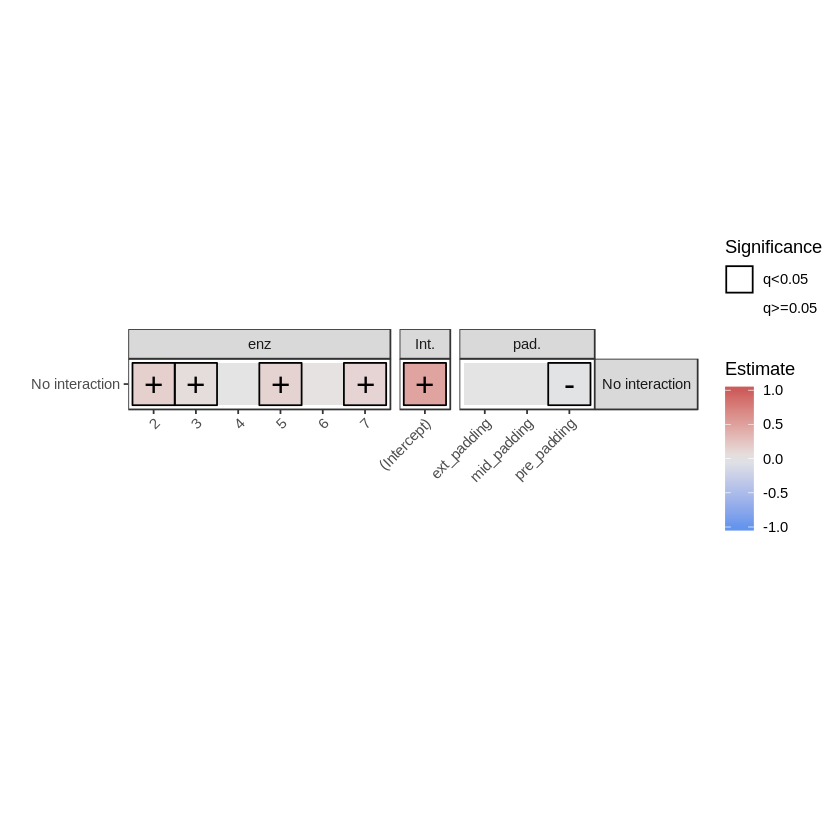

In [67]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g3_task2 <- plot_coefs_inter(lm_f1_task2_B)
g3_task2

ggsave("B.eps", device="eps", path=file_path)

In [68]:
B_df2 <- postproc_lm(lm_f1_task2_B)
#B_df2_proc <- separating_interactions("architecture", "type_padding", B_df2)

# Dividing lm in representable tiles
#arch_df2_2 <- dividing_rownames("architecture", sm2_df2_proc$estimates_df)
enz_df2_B <- dividing_rownames("enz_type", B_df2)
pad_df2_B <- dividing_rownames("type_padding", B_df2)

In [84]:
# comparison predictions
new_df <- data.frame("enz_type" = c("1", "1"), "type_padding" = c("pre_padding", "post_padding"), 
                     "architecture" = c("only_denses", "only_denses"))
predict(lm_f1_task2_B, new_df)

1         2 
0.4568519 0.4837102

## C. What is the effect of changing from the standard dense padding to sparse padding?

In [69]:
# interactions non significant
soa2_pad <- c("post_padding", "strf_padding", "rnd_padding", "zoom_padding")
lm_f1_task2_C <- lm(equation2,data=subset(scores_task2_dcasted, architecture %in% soa_arch 
                                           & type_padding %in% soa2_pad))
summary(lm_f1_task2_C)


Call:
lm(formula = equation2, data = subset(scores_task2_dcasted, architecture %in% 
    soa_arch & type_padding %in% soa2_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44954 -0.02996 -0.00160  0.03050  0.32921 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.4981867  0.0143139  34.804  < 2e-16 ***
enz_type2                 0.1584222  0.0169365   9.354  < 2e-16 ***
enz_type3                 0.0636325  0.0169365   3.757 0.000211 ***
enz_type4                -0.0149684  0.0169365  -0.884 0.377591    
enz_type5                 0.1322510  0.0169365   7.809 1.28e-13 ***
enz_type6                -0.0007323  0.0169365  -0.043 0.965542    
enz_type7                 0.0495055  0.0169365   2.923 0.003760 ** 
type_paddingrnd_padding  -0.0981544  0.0128028  -7.667 3.20e-13 ***
type_paddingstrf_padding -0.0067599  0.0128028  -0.528 0.597929    
type_paddingzoom_padding -0.0381935  0.0128028  -2.983 0.003113 ** 
---

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


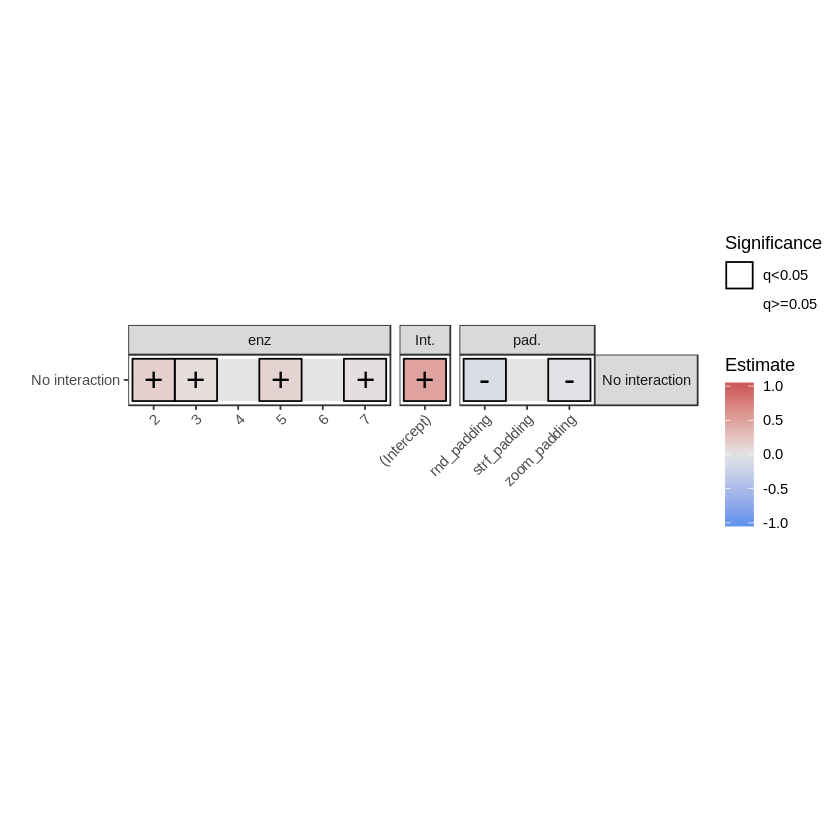

In [70]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g4_task2 <- plot_coefs_inter(lm_f1_task2_C)
g4_task2

ggsave("C.eps", device="eps", path=file_path)

In [71]:
C_df2 <- postproc_lm(lm_f1_task2_C)
#C_df2_proc <- separating_interactions("architecture", "type_padding", sm2_df2)

# Dividing lm in representable tiles
#arch_df2_2 <- dividing_rownames("architecture", sm2_df2_proc$estimates_df)
enz_df2_C <- dividing_rownames("enz_type", C_df2)
pad_df2_C <- dividing_rownames("type_padding", C_df2)

In [87]:
# comparison predictions
new_df <- data.frame("enz_type" = c("1", "1", "1"), "type_padding" = c("post_padding", "rnd_padding", 
                                                                       "zoom_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv"))
predict(lm_f1_task2_C, new_df)

1         2         3 
0.4981867 0.4000323 0.4599931

# D. Is an ensemble of paddings beneficial?

In [72]:
soa_pad <- c("post_padding", "strf_padding", "aug_padding")
#changing reference 
scores_task2_dcasted$architecture <- relevel(scores_task2_dcasted$architecture, "stack_conv")
scores_task2_dcasted$type_padding <- relevel(scores_task2_dcasted$type_padding, "aug_padding")

lm_f1_task2_D <- lm(equation3, data=subset(scores_task2_dcasted, 
                                           type_padding %in% soa_pad))
summary(lm_f1_task2_D)


Call:
lm(formula = equation3, data = subset(scores_task2_dcasted, type_padding %in% 
    soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54992 -0.02824 -0.00008  0.02566  0.34998 

Coefficients:
                                                  Estimate Std. Error t value
(Intercept)                                       0.421404   0.011650  36.172
architectureonly_denses                           0.027212   0.012762   2.132
architecture1_conv                                0.032003   0.012762   2.508
enz_type2                                         0.165884   0.011255  14.739
enz_type3                                         0.092673   0.011255   8.234
enz_type4                                         0.003403   0.011255   0.302
enz_type5                                         0.154250   0.011255  13.705
enz_type6                                         0.038533   0.011255   3.424
enz_type7                                         0.123991   0.011255  11.016
t

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


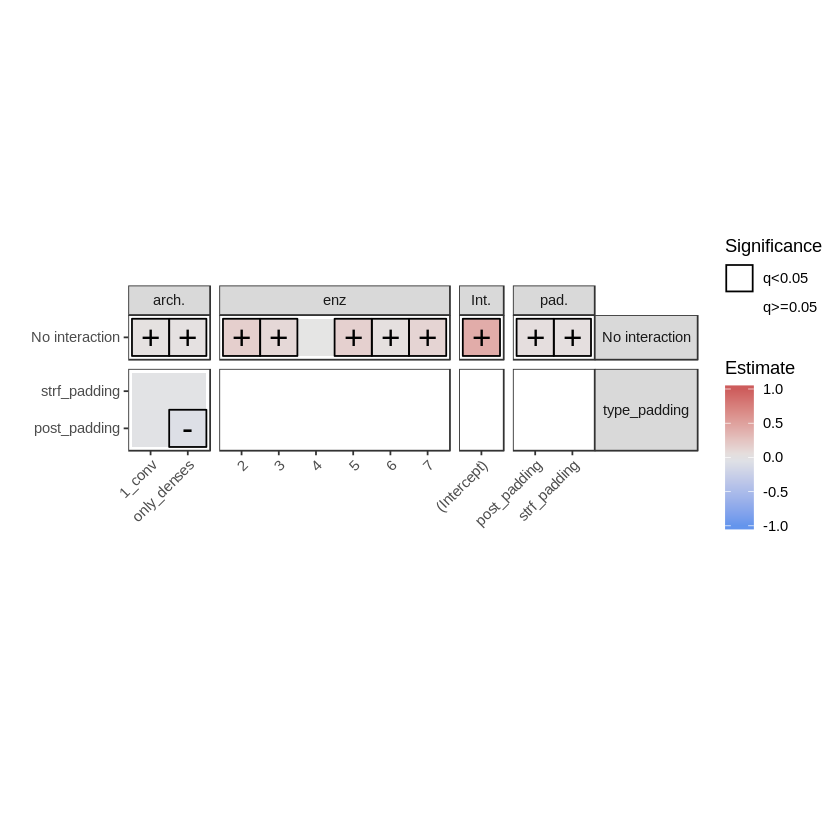

In [73]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g5_task2 <- plot_coefs_inter(lm_f1_task2_D)
g5_task2

ggsave("D.eps", device="eps", path=file_path)

In [74]:
D_df2 <- postproc_lm(lm_f1_task2_D)
D_df2_proc <- separating_interactions("architecture", "type_padding", D_df2)

arch_df2_D <- dividing_rownames("architecture", D_df2_proc$estimates_df)
enz_df2_D <- dividing_rownames("enz_type", D_df2_proc$estimates_df)
pad_df2_D <- dividing_rownames("type_padding", D_df2_proc$estimates_df)

In [98]:
new_df <- data.frame("enz_type" = c("1", "1", "1"), "type_padding" = c("aug_padding", "strf_padding", 
                                                                            "post_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv"))
predict(lm_f1_task2_D, new_df)

1         2         3 
0.4214041 0.4641948 0.4709548

In [99]:
new_df <- data.frame("enz_type" = c("1", "1", "1"), "type_padding" = c("aug_padding", "aug_padding", 
                                                                            "aug_padding"), 
                     "architecture" = c("stack_conv", "1_conv", "only_denses"))
predict(lm_f1_task2_D, new_df)

1         2         3 
0.4214041 0.4534071 0.4486164

In [102]:
new_df <- data.frame("enz_type" = c("1", "1"), "type_padding" = c("post_padding", "post_padding", 
                                                                  "aug_padding", "aug_padding"), 
                     "architecture" = c("stack_conv", "only_denses", "stack_conv", "only_denses"))
predict(lm_f1_task2_D, new_df)

1         2         3         4 
0.4709548 0.4259245 0.4214041 0.4486164

# E. How does enzyme type might affect differentlythe performances of some padding types?

In [75]:
soa_pad <- c("post_padding", "strf_padding")
#scores_task1_dcasted_aug <- scores_task1_dcasted
#changing reference
scores_task2_dcasted$type_padding <- relevel(scores_task2_dcasted$type_padding, "post_padding")

lm_f1_task2_E <- lm(equation4, data=subset(scores_task2_dcasted, type_padding %in% soa_pad))
summary(lm_f1_task2_E)


Call:
lm(formula = equation4, data = subset(scores_task2_dcasted, type_padding %in% 
    soa_pad))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57547 -0.02300  0.00090  0.02577  0.34416 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.4570784  0.0160386  28.499  < 2e-16 ***
architectureonly_denses            -0.0217440  0.0098216  -2.214 0.027393 *  
architecture1_conv                 -0.0001922  0.0098216  -0.020 0.984395    
enz_type2                           0.1619765  0.0212170   7.634 1.66e-13 ***
enz_type3                           0.0979910  0.0212170   4.619 5.20e-06 ***
enz_type4                          -0.0026738  0.0212170  -0.126 0.899779    
enz_type5                           0.1411368  0.0212170   6.652 9.42e-11 ***
enz_type6                           0.0746707  0.0212170   3.519 0.000482 ***
enz_type7                           0.1401308  0.0212170   6.605 1.26e-10 ***
t

Joining by: x1
Joining by: x2
Saving 6.67 x 6.67 in image


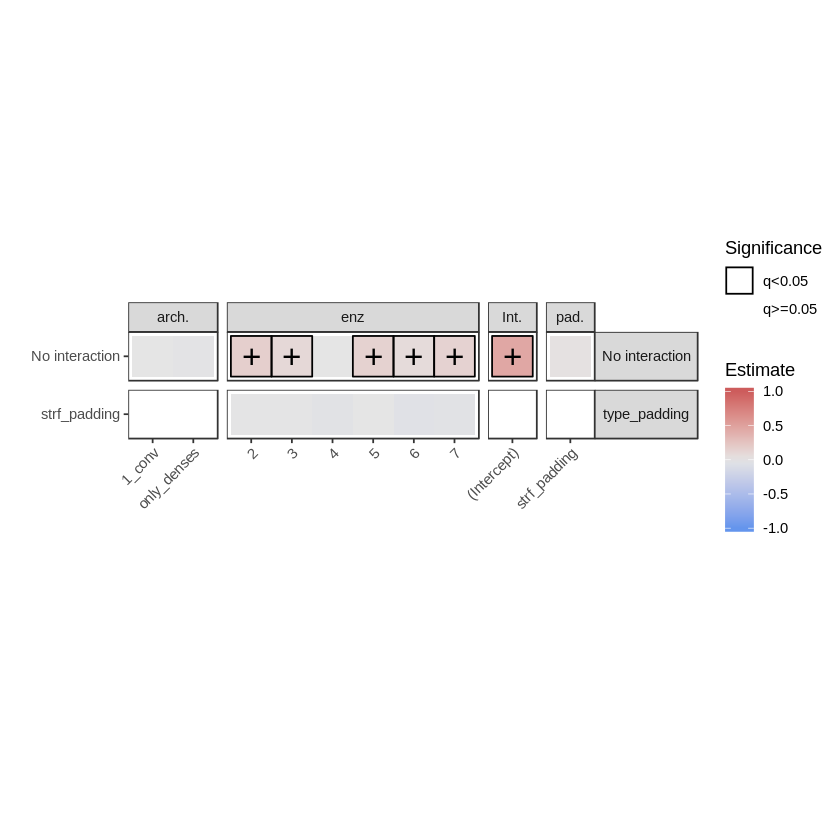

In [76]:
file_path <- paste0(absPath, "data/results/", task, "linear_models_f1/")

g6_task2 <- plot_coefs_inter(lm_f1_task2_E)
g6_task2

ggsave("E.eps", device="eps", path=file_path)

In [77]:
E_df2 <- postproc_lm(lm_f1_task2_E)
E_df2_proc <- separating_interactions("architecture", "type_padding", E_df2)

arch_df2_E <- dividing_rownames("architecture", E_df2_proc$estimates_df)
enz_df2_E <- dividing_rownames("enz_type", E_df2_proc$estimates_df)
pad_df2_E <- dividing_rownames("type_padding", E_df2_proc$estimates_df)

In [103]:
# comparison predictions
new_df <- data.frame("enz_type" = c("1", "2", "3", "4", "5", "6", "7"), 
                     "type_padding" = c("post_padding", "post_padding", "post_padding", 
                                        "post_padding", "post_padding","post_padding","post_padding"), 
                     "architecture" = c("stack_conv", "stack_conv", "stack_conv", "stack_conv", "stack_conv",
                                       "stack_conv", "stack_conv"))
predict(lm_f1_task2_E, new_df)

1         2         3         4         5         6         7 
0.4570784 0.6190549 0.5550695 0.4544047 0.5982152 0.5317491 0.5972092

## Construyendo tablas

## Full additive models

In [68]:
stargazer::stargazer(lm_f1_task1_additive, lm_f1_task2_additive,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:lm_full_additive",
  title = "Full additive linear models on F1-score. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Dec 30, 2019 - 12:18:44 AM
\begin{table}[!htbp] \centering 
  \caption{Full additive linear models on F1-score. The reference levels were omitted.} 
  \label{tab:lm_full_additive} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecture1\_conv & $-$0.063$^{***}$ ($-$0.069, $-$0.057) & 0.021$^{***}$ (0.011, 0.030) \\ 
  architecturestack\_conv & $-$0.052$^{***}$ ($-$0.058, $-$0.046) & 0.010$^{**}$ (0.0004, 0.020) \\ 
  enz\_type1 & 0.012$^{***}$ (0.008, 0.017) &  \\ 
  enz\_type2 &  & 0.167$^{***}$ (0.152, 0.182) \\ 
  enz\_type3 &  & 0.097$^{***}$ (0.082, 0.111) \\ 
  enz\_type4 &  & 0.008 ($-$0.007, 0.023) \\ 
  enz\_type5 &  & 0.167$^{***}$ (0.152, 0.182) \\ 
  enz\_type6 &  & 0.044$^{***}$ (0.029, 0.059) \\ 
  enz\_type7 &  & 0.100$^{***}$ (0.085, 0.115) \\ 
  type\_paddingaug\_padding & $-$0.06

## A. Does padding position affect performance?

In [69]:
stargazer::stargazer(lm_f1_task1_A, lm_f1_task2_A,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:A",
  title = "Linear model on F1-score to analyze if padding position affects performance. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Dec 30, 2019 - 12:28:30 AM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze if padding position affects performance. The reference levels were omitted.} 
  \label{tab:A} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 enz\_type1 & 0.006 ($-$0.005, 0.016) &  \\ 
  enz\_type2 &  & 0.157$^{***}$ (0.130, 0.184) \\ 
  enz\_type3 &  & 0.060$^{***}$ (0.033, 0.087) \\ 
  enz\_type4 &  & $-$0.013 ($-$0.040, 0.014) \\ 
  enz\_type5 &  & 0.136$^{***}$ (0.109, 0.163) \\ 
  enz\_type6 &  & 0.024$^{*}$ ($-$0.003, 0.051) \\ 
  enz\_type7 &  & 0.125$^{***}$ (0.098, 0.152) \\ 
  type\_paddingext\_padding & $-$0.004 ($-$0.018, 0.010) & $-$0.014 ($-$0.034, 0.007) \\ 
  type\_paddingmid\_padding & $-$0.006 ($-$0.020, 0.009) & 0.004 ($-$0.017, 0.024) \\ 
  type\_paddingpre\_padding & $-$0.017

## B. What is the effect of switching between dense paddings?

In [70]:
stargazer::stargazer(lm_f1_task1_B, lm_f1_task2_B,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:B",
  title = "Linear model on F1-score to analyze what is the effect of switching between dense paddings. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Dec 30, 2019 - 12:28:30 AM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze what is the effect of switching between dense paddings. The reference levels were omitted.} 
  \label{tab:B} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 enz\_type1 & 0.006 ($-$0.005, 0.016) &  \\ 
  enz\_type2 &  & 0.157$^{***}$ (0.130, 0.184) \\ 
  enz\_type3 &  & 0.060$^{***}$ (0.033, 0.087) \\ 
  enz\_type4 &  & $-$0.013 ($-$0.040, 0.014) \\ 
  enz\_type5 &  & 0.136$^{***}$ (0.109, 0.163) \\ 
  enz\_type6 &  & 0.024$^{*}$ ($-$0.003, 0.051) \\ 
  enz\_type7 &  & 0.125$^{***}$ (0.098, 0.152) \\ 
  type\_paddingext\_padding & $-$0.004 ($-$0.018, 0.010) & $-$0.014 ($-$0.034, 0.007) \\ 
  type\_paddingmid\_padding & $-$0.006 ($-$0.020, 0.009) & 0.004 ($-$0.017, 0.024) \\ 
  type\_paddingpre\_pad

## C. What is the effect of changing from the standard dense padding to sparse paddings?

In [71]:
stargazer::stargazer(lm_f1_task1_C, lm_f1_task2_C,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:C",
  title = "Linear model on F1-score to analyze what is the effect of changing from the standard dense padding to sparse paddings. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Dec 30, 2019 - 12:28:30 AM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze what is the effect of changing from the standard dense padding to sparse paddings. The reference levels were omitted.} 
  \label{tab:C} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 enz\_type1 & 0.022$^{***}$ (0.014, 0.029) &  \\ 
  enz\_type2 &  & 0.158$^{***}$ (0.125, 0.192) \\ 
  enz\_type3 &  & 0.064$^{***}$ (0.030, 0.097) \\ 
  enz\_type4 &  & $-$0.015 ($-$0.048, 0.018) \\ 
  enz\_type5 &  & 0.132$^{***}$ (0.099, 0.165) \\ 
  enz\_type6 &  & $-$0.001 ($-$0.034, 0.032) \\ 
  enz\_type7 &  & 0.050$^{***}$ (0.016, 0.083) \\ 
  type\_paddingrnd\_padding & $-$0.067$^{***}$ ($-$0.078, $-$0.056) & $-$0.098$^{***}$ ($-$0.123, $-$0.073) \\ 
  type\_paddingstrf\_padding & $-$0.028$^{***}$ ($-$0.039, 

## D. Is an ensemble of paddings beneficial?

In [72]:
stargazer::stargazer(lm_f1_task1_D, lm_f1_task2_D,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:D",
  title = "Linear model on F1-score to analyze if an ensemble of paddings is beneficial. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Dec 30, 2019 - 12:28:30 AM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze if an ensemble of paddings is beneficial. The reference levels were omitted.} 
  \label{tab:D} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecture1\_conv & $-$0.034$^{***}$ ($-$0.048, $-$0.020) & 0.032$^{**}$ (0.007, 0.057) \\ 
  enz\_type2 &  & 0.166$^{***}$ (0.144, 0.188) \\ 
  enz\_type3 &  & 0.093$^{***}$ (0.071, 0.115) \\ 
  enz\_type4 &  & 0.003 ($-$0.019, 0.025) \\ 
  enz\_type5 &  & 0.154$^{***}$ (0.132, 0.176) \\ 
  enz\_type6 &  & 0.039$^{***}$ (0.016, 0.061) \\ 
  enz\_type7 &  & 0.124$^{***}$ (0.102, 0.146) \\ 
  architectureonly\_denses & 0.110$^{***}$ (0.096, 0.123) & 0.027$^{**}$ (0.002, 0.052) \\ 
  enz\_type1 & 0.009$^{***}$ (0.003, 0.015) &  \\ 
  type\_paddingpost\_padd

## E. How does enzyme type might affect differently the performances of some padding types?

In [73]:
stargazer::stargazer(lm_f1_task1_E, lm_f1_task2_E,   
          column.labels = c("Task 1", "Task 2"), 
  model.numbers = FALSE,
  ci = TRUE, ci.level = 0.95, 
  single.row = TRUE, omit.table.layout = "mdl", 
  label = "tab:E",
  title = "Linear model on F1-score to analyze how does enzyme type might affect differently the performances of some padding types. The reference levels were omitted.", 
  type = 'latex'
          #,out = paste0(dir_out, "/1_cv_models.tex"
         )


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Dec 30, 2019 - 12:28:31 AM
\begin{table}[!htbp] \centering 
  \caption{Linear model on F1-score to analyze how does enzyme type might affect differently the performances of some padding types. The reference levels were omitted.} 
  \label{tab:E} 
\begin{tabular}{@{\extracolsep{5pt}}lcc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Task 1 & Task 2 \\ 
 architecture1\_conv & 0.005 ($-$0.003, 0.013) & $-$0.0002 ($-$0.019, 0.019) \\ 
  enz\_type2 &  & 0.162$^{***}$ (0.120, 0.204) \\ 
  enz\_type3 &  & 0.098$^{***}$ (0.056, 0.140) \\ 
  enz\_type4 &  & $-$0.003 ($-$0.044, 0.039) \\ 
  enz\_type5 &  & 0.141$^{***}$ (0.100, 0.183) \\ 
  enz\_type6 &  & 0.075$^{***}$ (0.033, 0.116) \\ 
  enz\_type7 &  & 0.140$^{***}$ (0.099, 0.182) \\ 
  architectureonly\_denses & 0.050$^{***}$ (0.042, 0.058) & $-$0.022$^{**}$ ($-$0.041, $-$0.002) \\ 
  enz\_type1 & 0.009$^{*}$ ($-$0.0

## Grobbing

## Full model

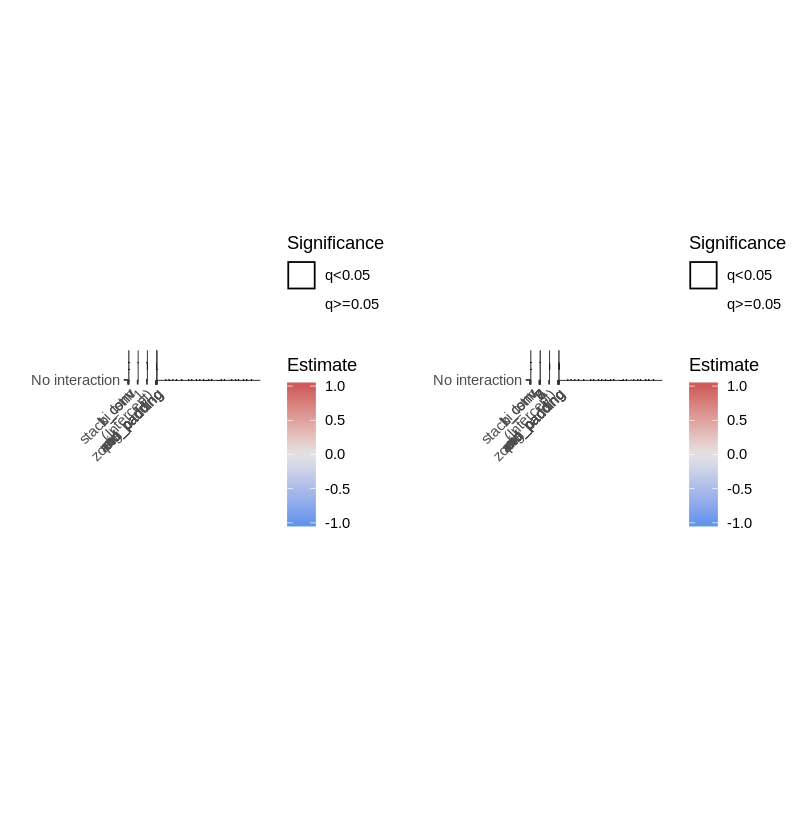

In [409]:
options(repr.plot.width=6.7)
gs = list(ggplotGrob(g1_task1), ggplotGrob(g1_task2))
grid.arrange(grobs = gs, ncol=2)